In [20]:
%pip install pandas 
%pip install python-dotenv
%pip install -U scikit-learn
%pip install sun_position_calculator
%pip install requests
%pip install docxtpl
%pip install matplotlib
%pip install tabulate
%pip install pyxirr
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
#local models
from typing import Dict
from models.econometrics import Cost, Currency
from models.components import Component
from models.econometrics import Cost
from models.geometry import Orientation
from models.photovoltaic import Photovoltaic
import pandas as pd

In [22]:
#local env variables
from dotenv import dotenv_values
config = dotenv_values(".env.local")

# Building references

## Address and general info🌎

In [23]:
#cspell:disable


#init proyect
from models.components import Tech
from models.consumption import Energetic
from models.inventory import Building, Project

project:Project = Project(
    title='Sistema Fotovoltaico OnGrid-Mixto',
    building = Building(
        geolocation=(-33.908104,-71.715771),
        name='PSR San Enrique',
        address='Fundo San Enrique SN CV-1,\nSanto Domingo',
        city='Santo Domingo'),
    technology= [Tech.PHOTOVOLTAIC],
    consumption= {
        'description':'main',
        'energetic':Energetic.ELI,
        'cost_increment':7/100,
        'consumption':[
            (444,"23-12-2023",69900),
            (490,"24-01-2023",78900),
            (354,"21-02-2023",57700),
            (448,"24-03-2023",72700),
            (458,"24-04-2023",86000),
            (601,"23-05-2023",117300),
            (789,"24-06-2023",158700),
            (709,"24-07-2023",128300),
            (713,"25-08-2023",129100),
            (368,"23-10-2023",66700),
            ],
        }
    )

getting weather data...
api request URL https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_SRF_ALB,SZA,WS10M&community=RE&latitude=-33.908104&longitude=-71.715771&start=20230101&end=20231231&format=JSON
getting currencies data...
set $1 Peso Chileno... on USD$0.00 
set $1 UF............. on USD$42.16 
set $1 UTM............ on USD$73.80 
set $1 Euro........... on USD$1.09 
set $1 Pound.......... on USD$1.27 
set $1 Real........... on USD$0.20 
adding consumptions data...


# Integration 

## Machine Components 🎡

In [24]:
#cspell: disable

#clean previous load
project.components = {}
from IPython.display import clear_output

from models.energy_storage import Battery
from models.photovoltaic import Length, PvTechnicalSheet
clear_output(wait=True)

# assembly projects components
project.add_component(
    'generación',
    Photovoltaic(project.weather,'Módulo  FV x6',
                reference='https://www.tiendatecnored.cl/modulo-fotovoltaico-650w-canadian-solar.html',
                specification='Solar Panel PV 650W 48V',
                quantity=5,
                cost=None,
                orientation=Orientation(15,42.21),
                technical_sheet=PvTechnicalSheet(power=655,area=(130.3,238.4,Length.CM)),
                ),

    generator=True
    )

project.add_component(
    'auxiliar',
    Component('Inversor Híbrido',
                model='Voltronic 5kW 48V',
                reference='https://solarbex.com/comprar/inversor-hibrido-5kw-48v-axpert/',
                specification='Híbrido 5kW Monofásico',
                cost_per_unit=Cost(869,Currency.EUR)),
    Component('Controlador de Carga',
                model='Enertik 80A 12/24V',
                specification='1000W to 2000 24V output',
                cost_per_unit=Cost(101600,Currency.CLP)),
    Component('medidor bidireccional',
                model='Elster AS1440',
                specification='Trifasico',
                cost_per_unit=Cost(306990,Currency.CLP)),
    Battery('almacenamiento',
                model='MP GEL12-250',
                reference='https://www.tiendatecnored.cl/bateria-gel-ciclo-profundo-12v-250ah.html',
                cost_per_unit=Cost(305990,Currency.CLP),
                volt=12,
                charge=250,
                demand=project.building.consumption_forecast(['main'])['energy'].to_list(),
                autonomy=1,
                )
    )

project.add_component(
    'obras',
    Component(description='instalación eléctrica',
            specification='H/P eléctrico',
            cost_per_unit=Cost(1,currency=Currency.UF),
            quantity=8*5,
            ),
    Component(description='estructura de soporte',
            specification='elementos fijación',
            cost_per_unit=Cost((4*800+11400/4+4*700+4000+500)),
            quantity=24
            )
)


inside cost pv :  245990.0 Currency.CLP
boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444


In [25]:
# psr_bucalemu.components['generación'][1].nominal_power()
#pv_log_model(1500) #clp/w

#bucket = project.bucket_list(Currency.CLP)
#bucket_df:DataFrame = bucket['bucket']


# Write Document 📒


In [26]:
import os
PATH = 'build/'+f'reporte_{project.building.name}/'

if not os.path.exists(PATH):
    #create
    os.makedirs(PATH)

### Saving results on EXCEL ❎

In [27]:
from models.plotter import toTable
toTable(project,PATH)

boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444

Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



C:\Users\crcam\AppData\Roaming\Python\Python312\site-packages\IPython\core\completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


### Generate Context->Doc📄✍️

In [28]:
from docxtpl import DocxTemplate # type: ignore
#init doc
#assembly proxy object 
memory_report = DocxTemplate("templates/memory_template.docx")
bidding_report = DocxTemplate("templates/bidding_template.docx")

## Write params and tables

In [29]:
#loading context
#cspell: disable
memory_report.render(project.context(template=memory_report))
bidding_report.render(project.context(template=bidding_report))


boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444
boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444
boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444
boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444


## Insert Plots 📊

boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444
boundaries in month 9 : 713 <-> 368
boundaries in month 11 : 368 <-> 444


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


plot_done


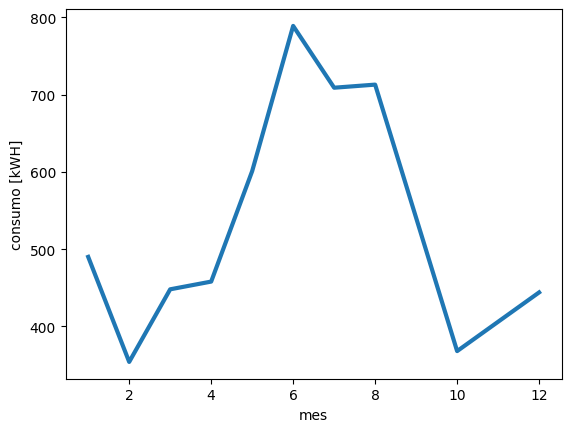

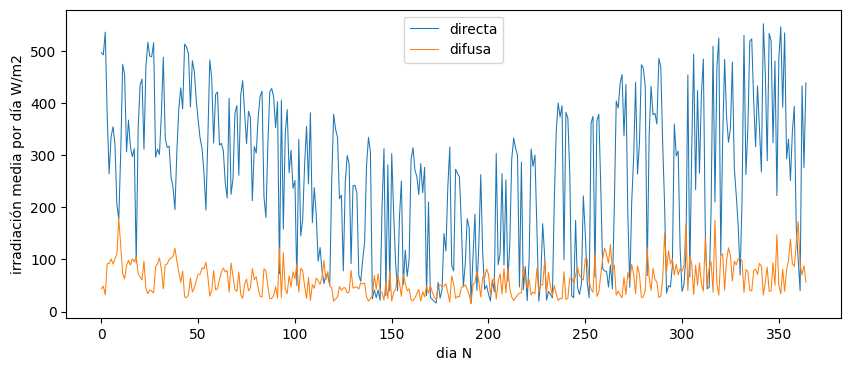

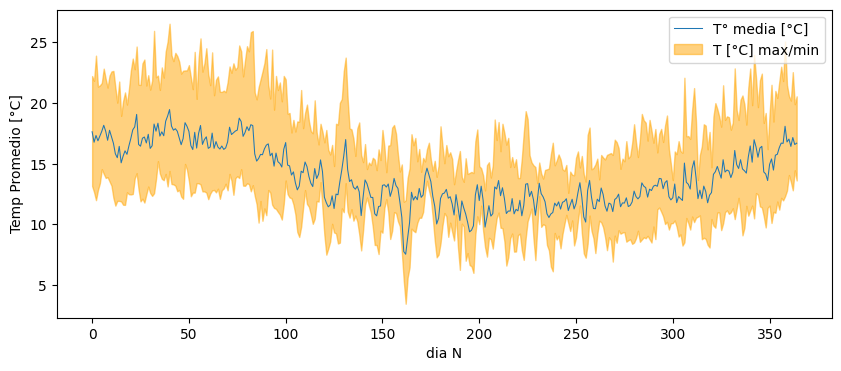

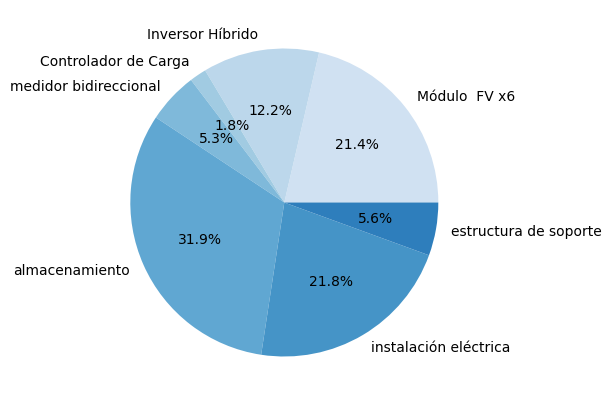

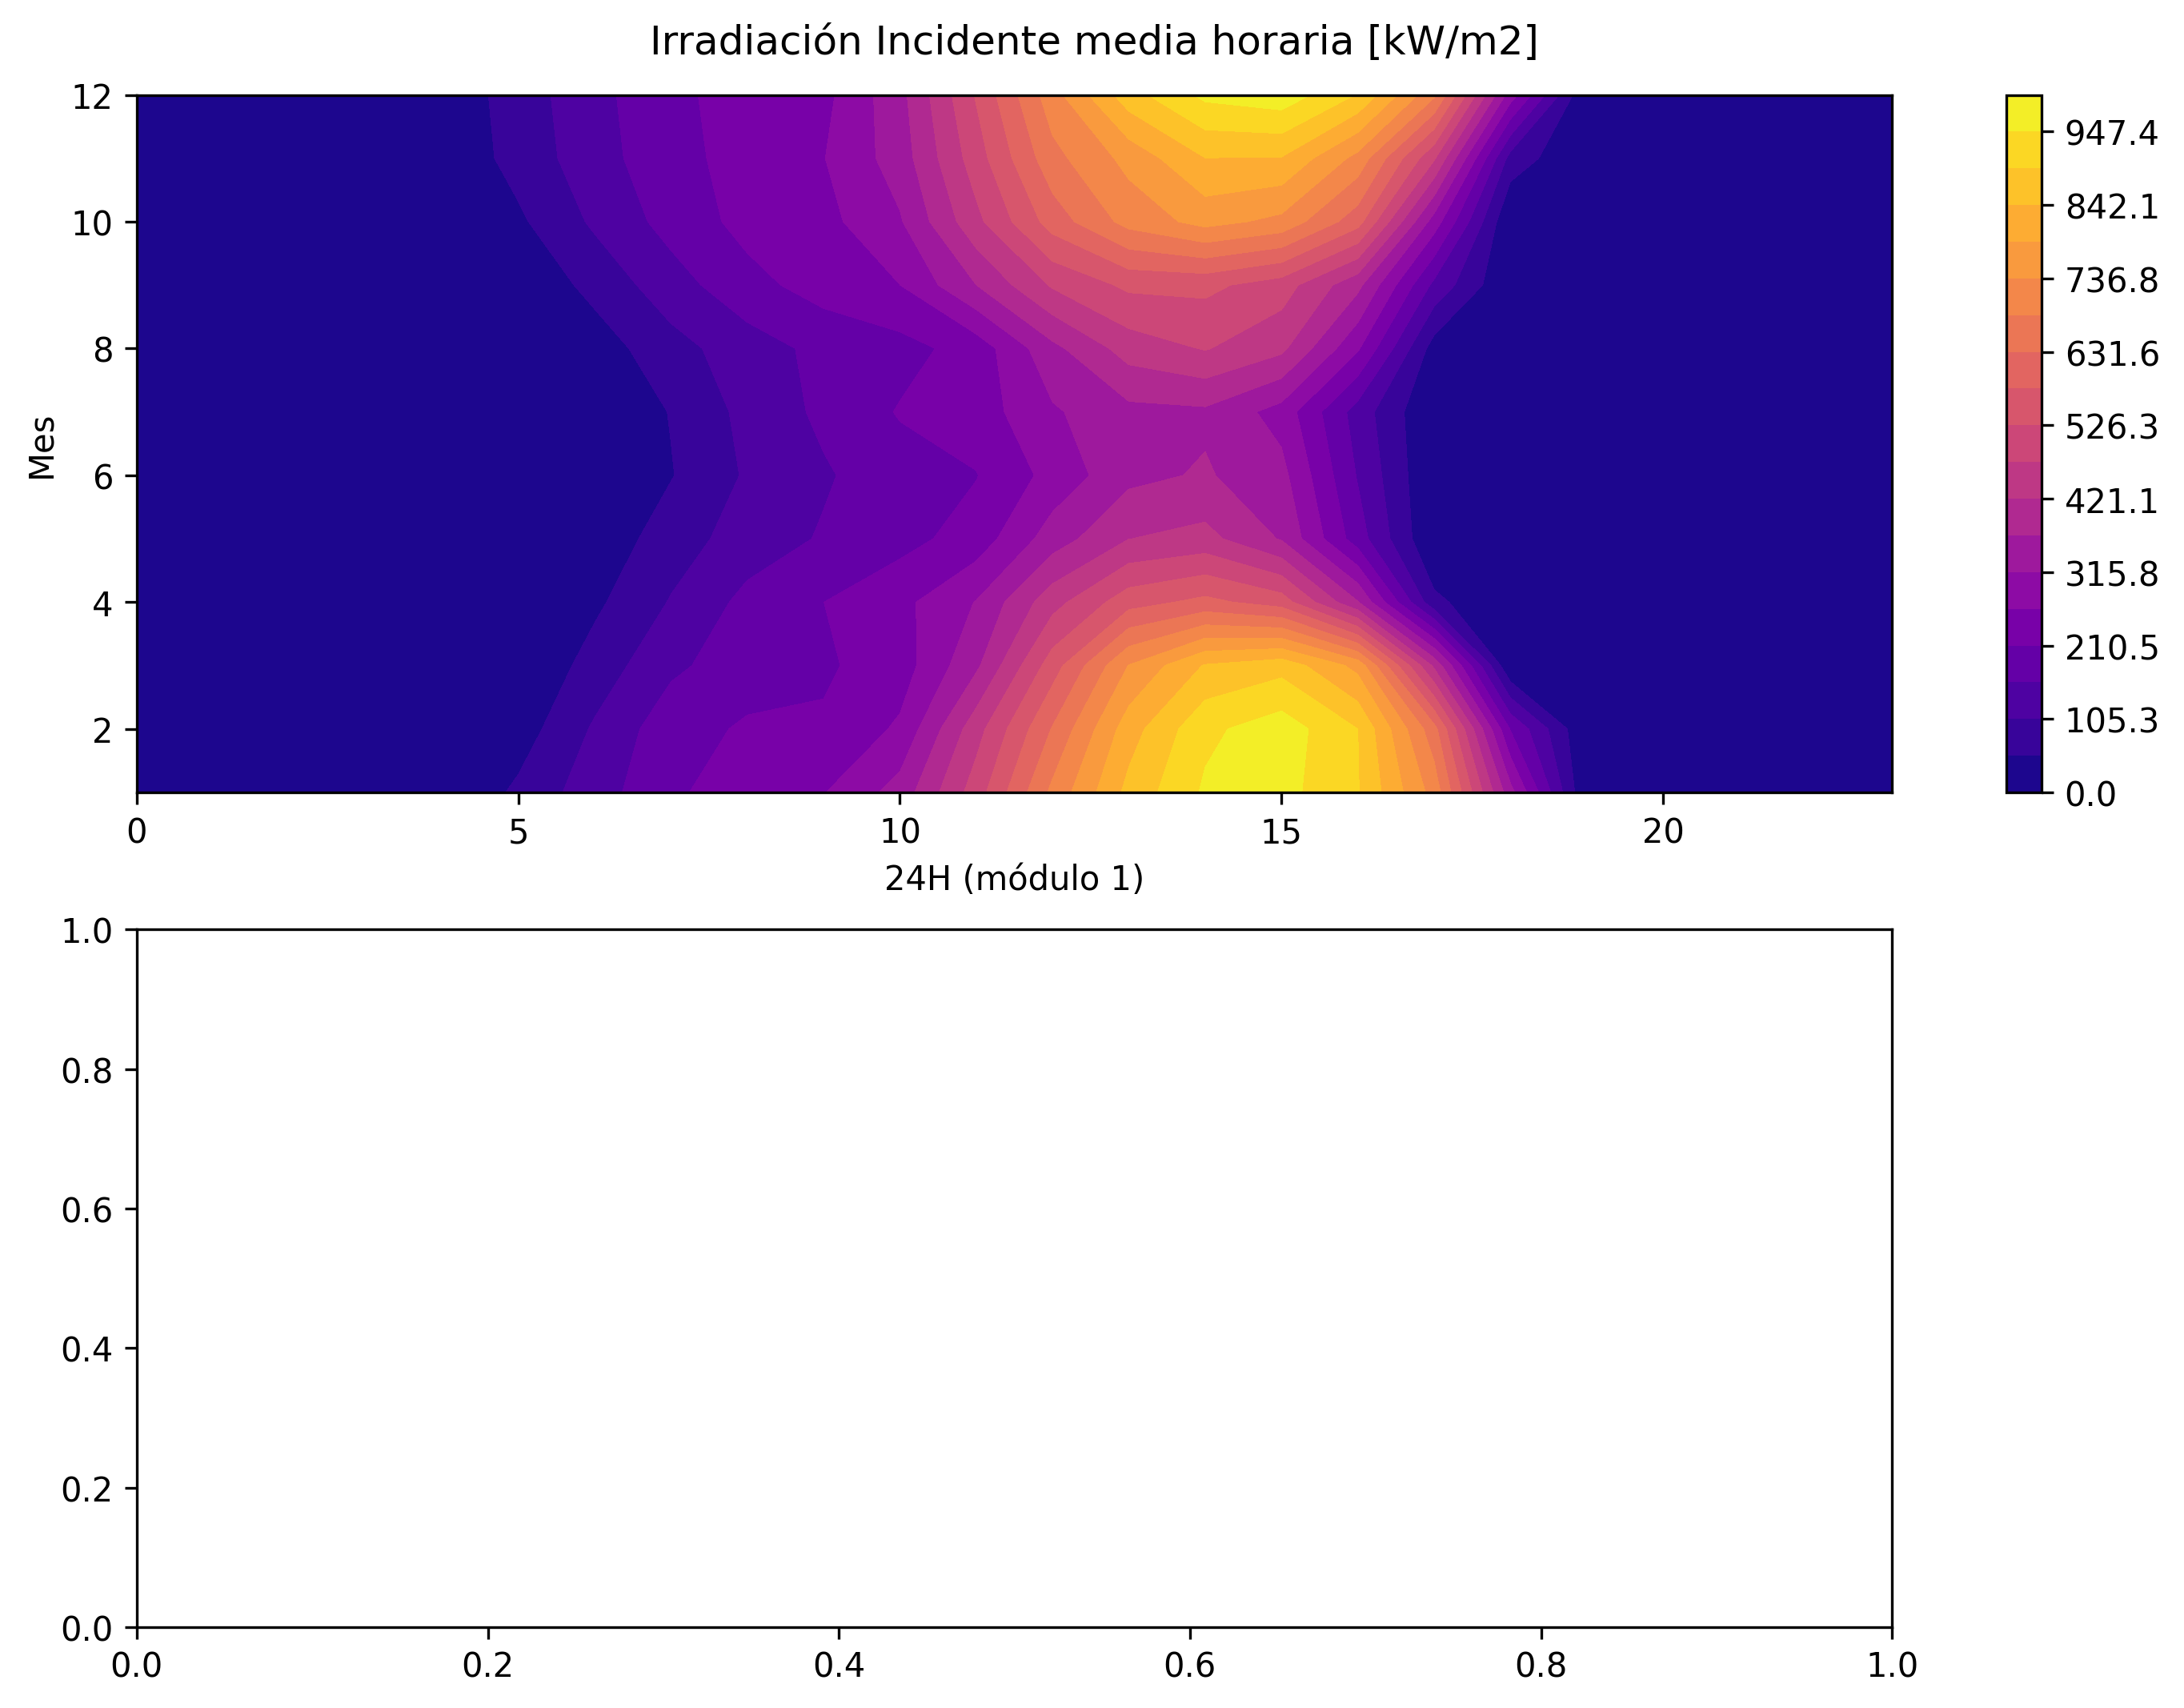

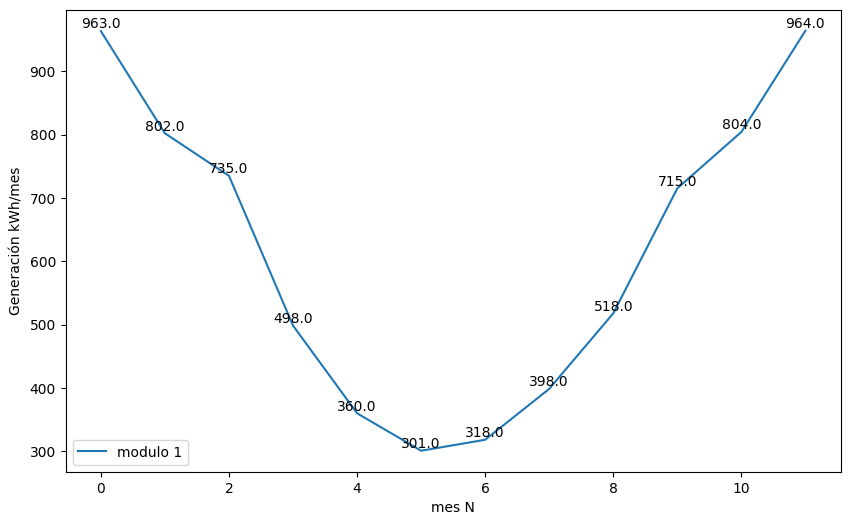

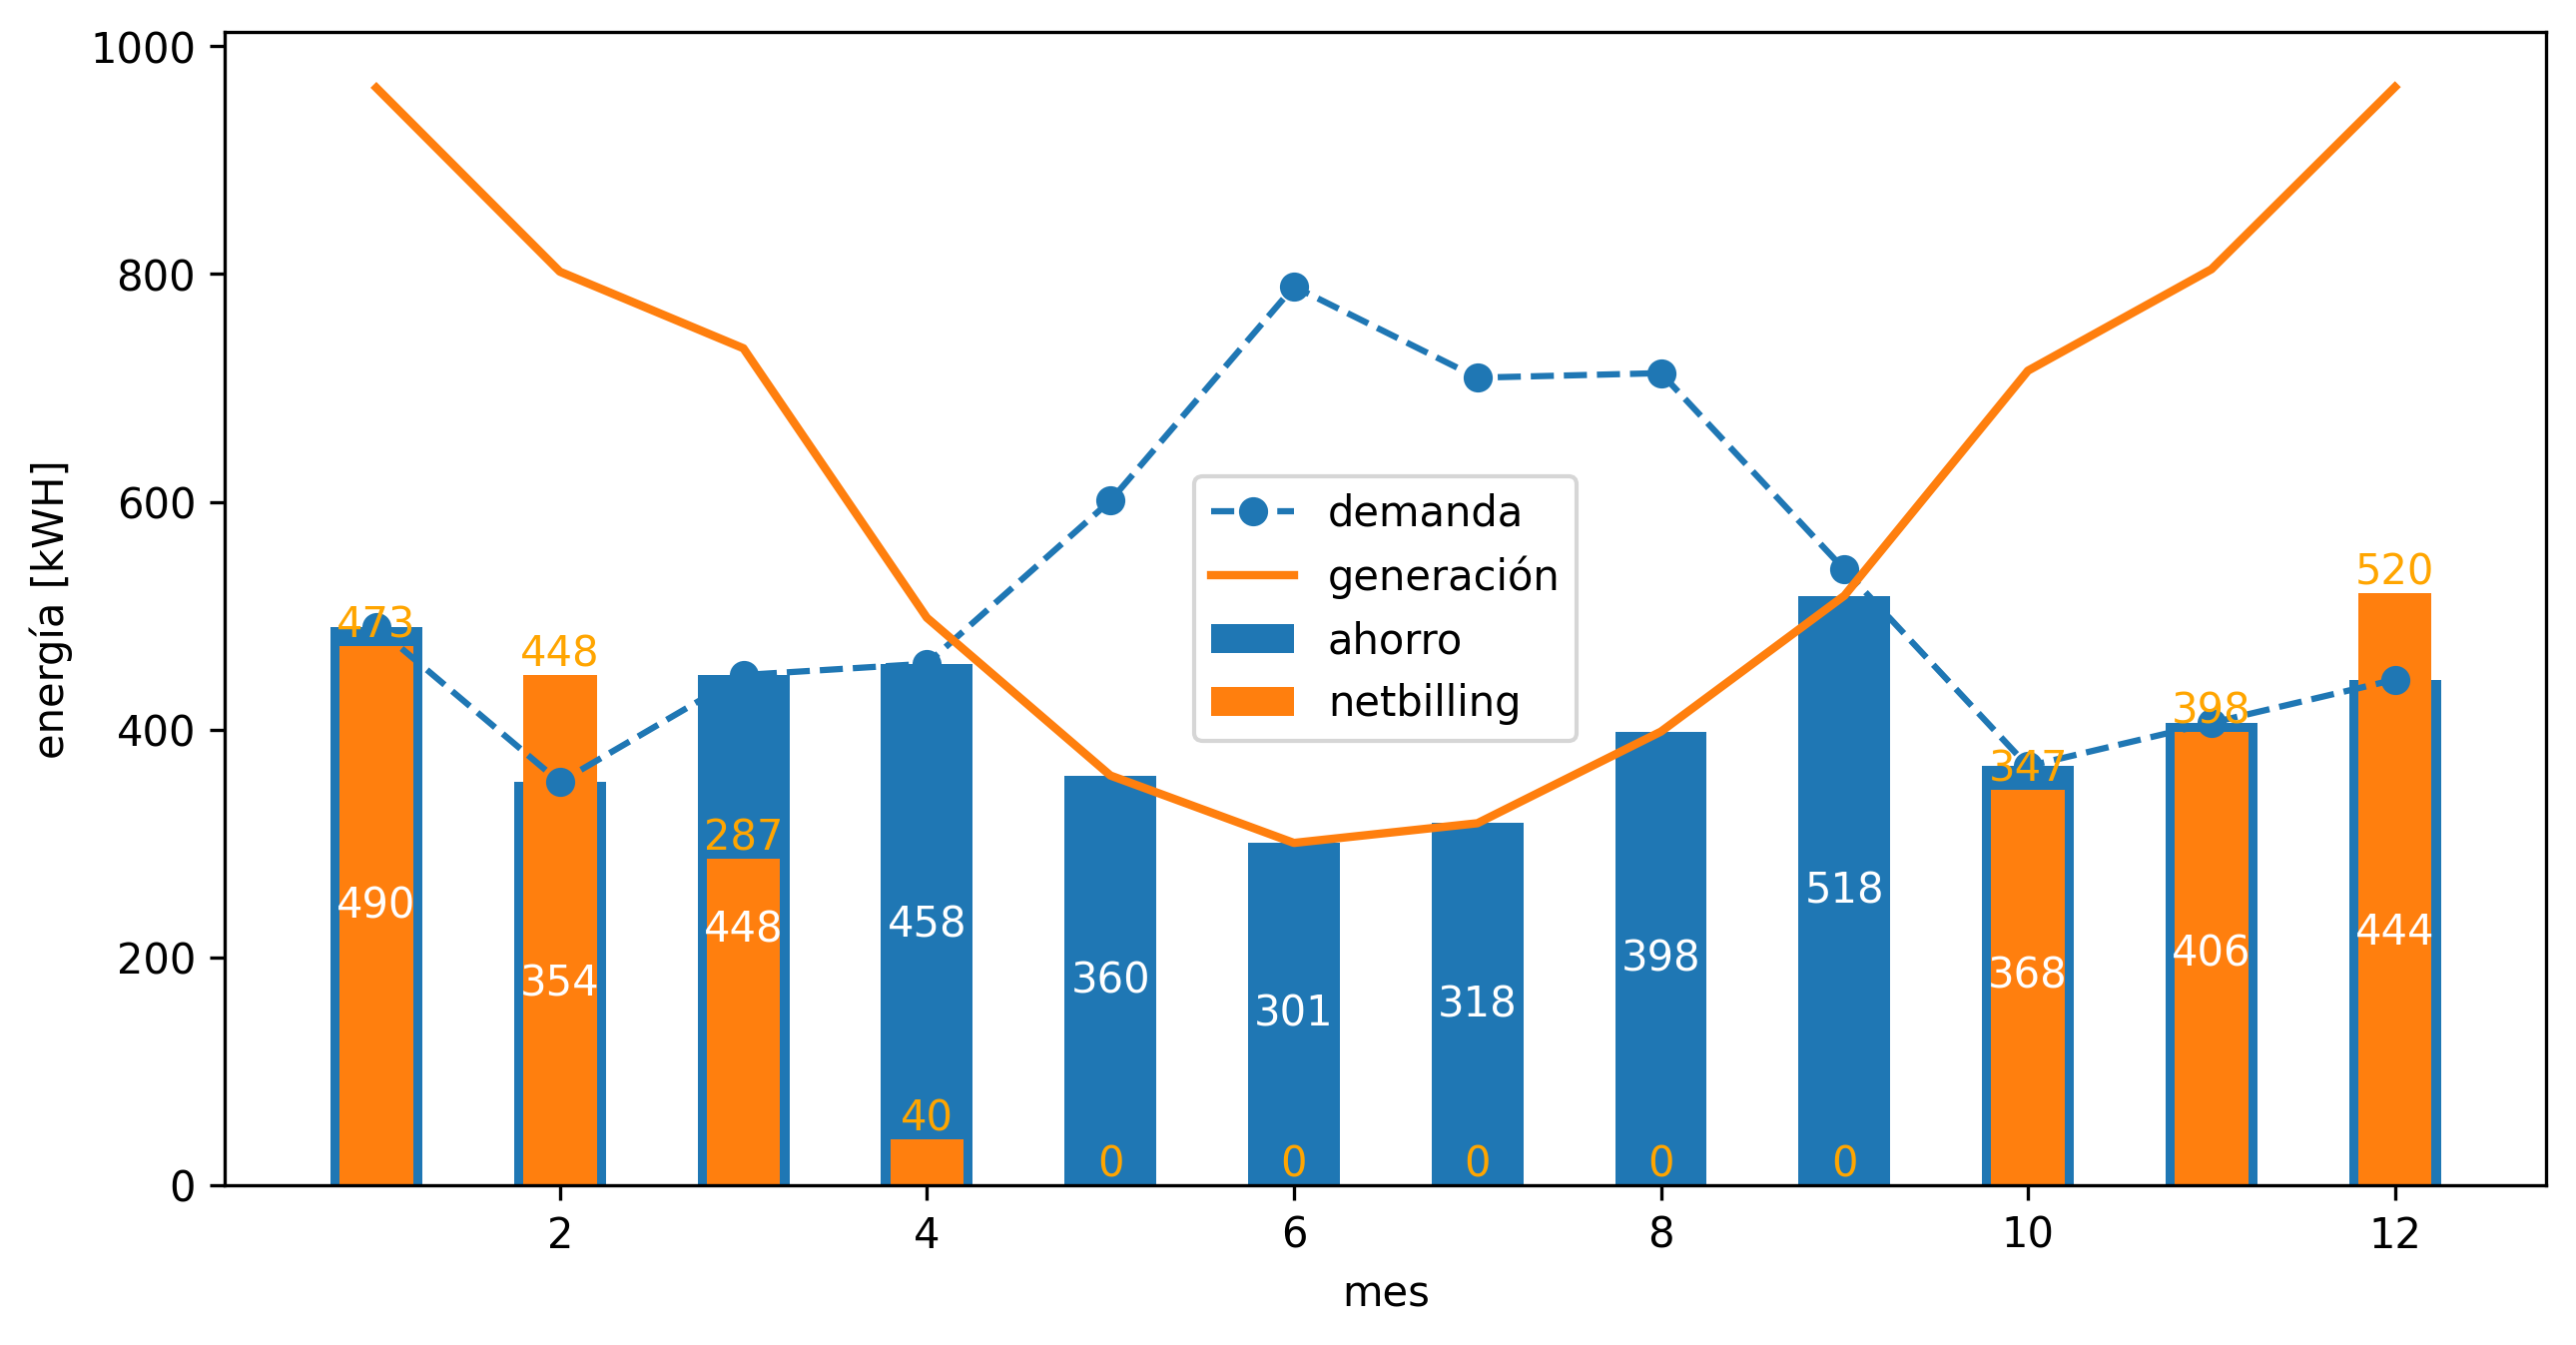

<Figure size 1920x1440 with 0 Axes>

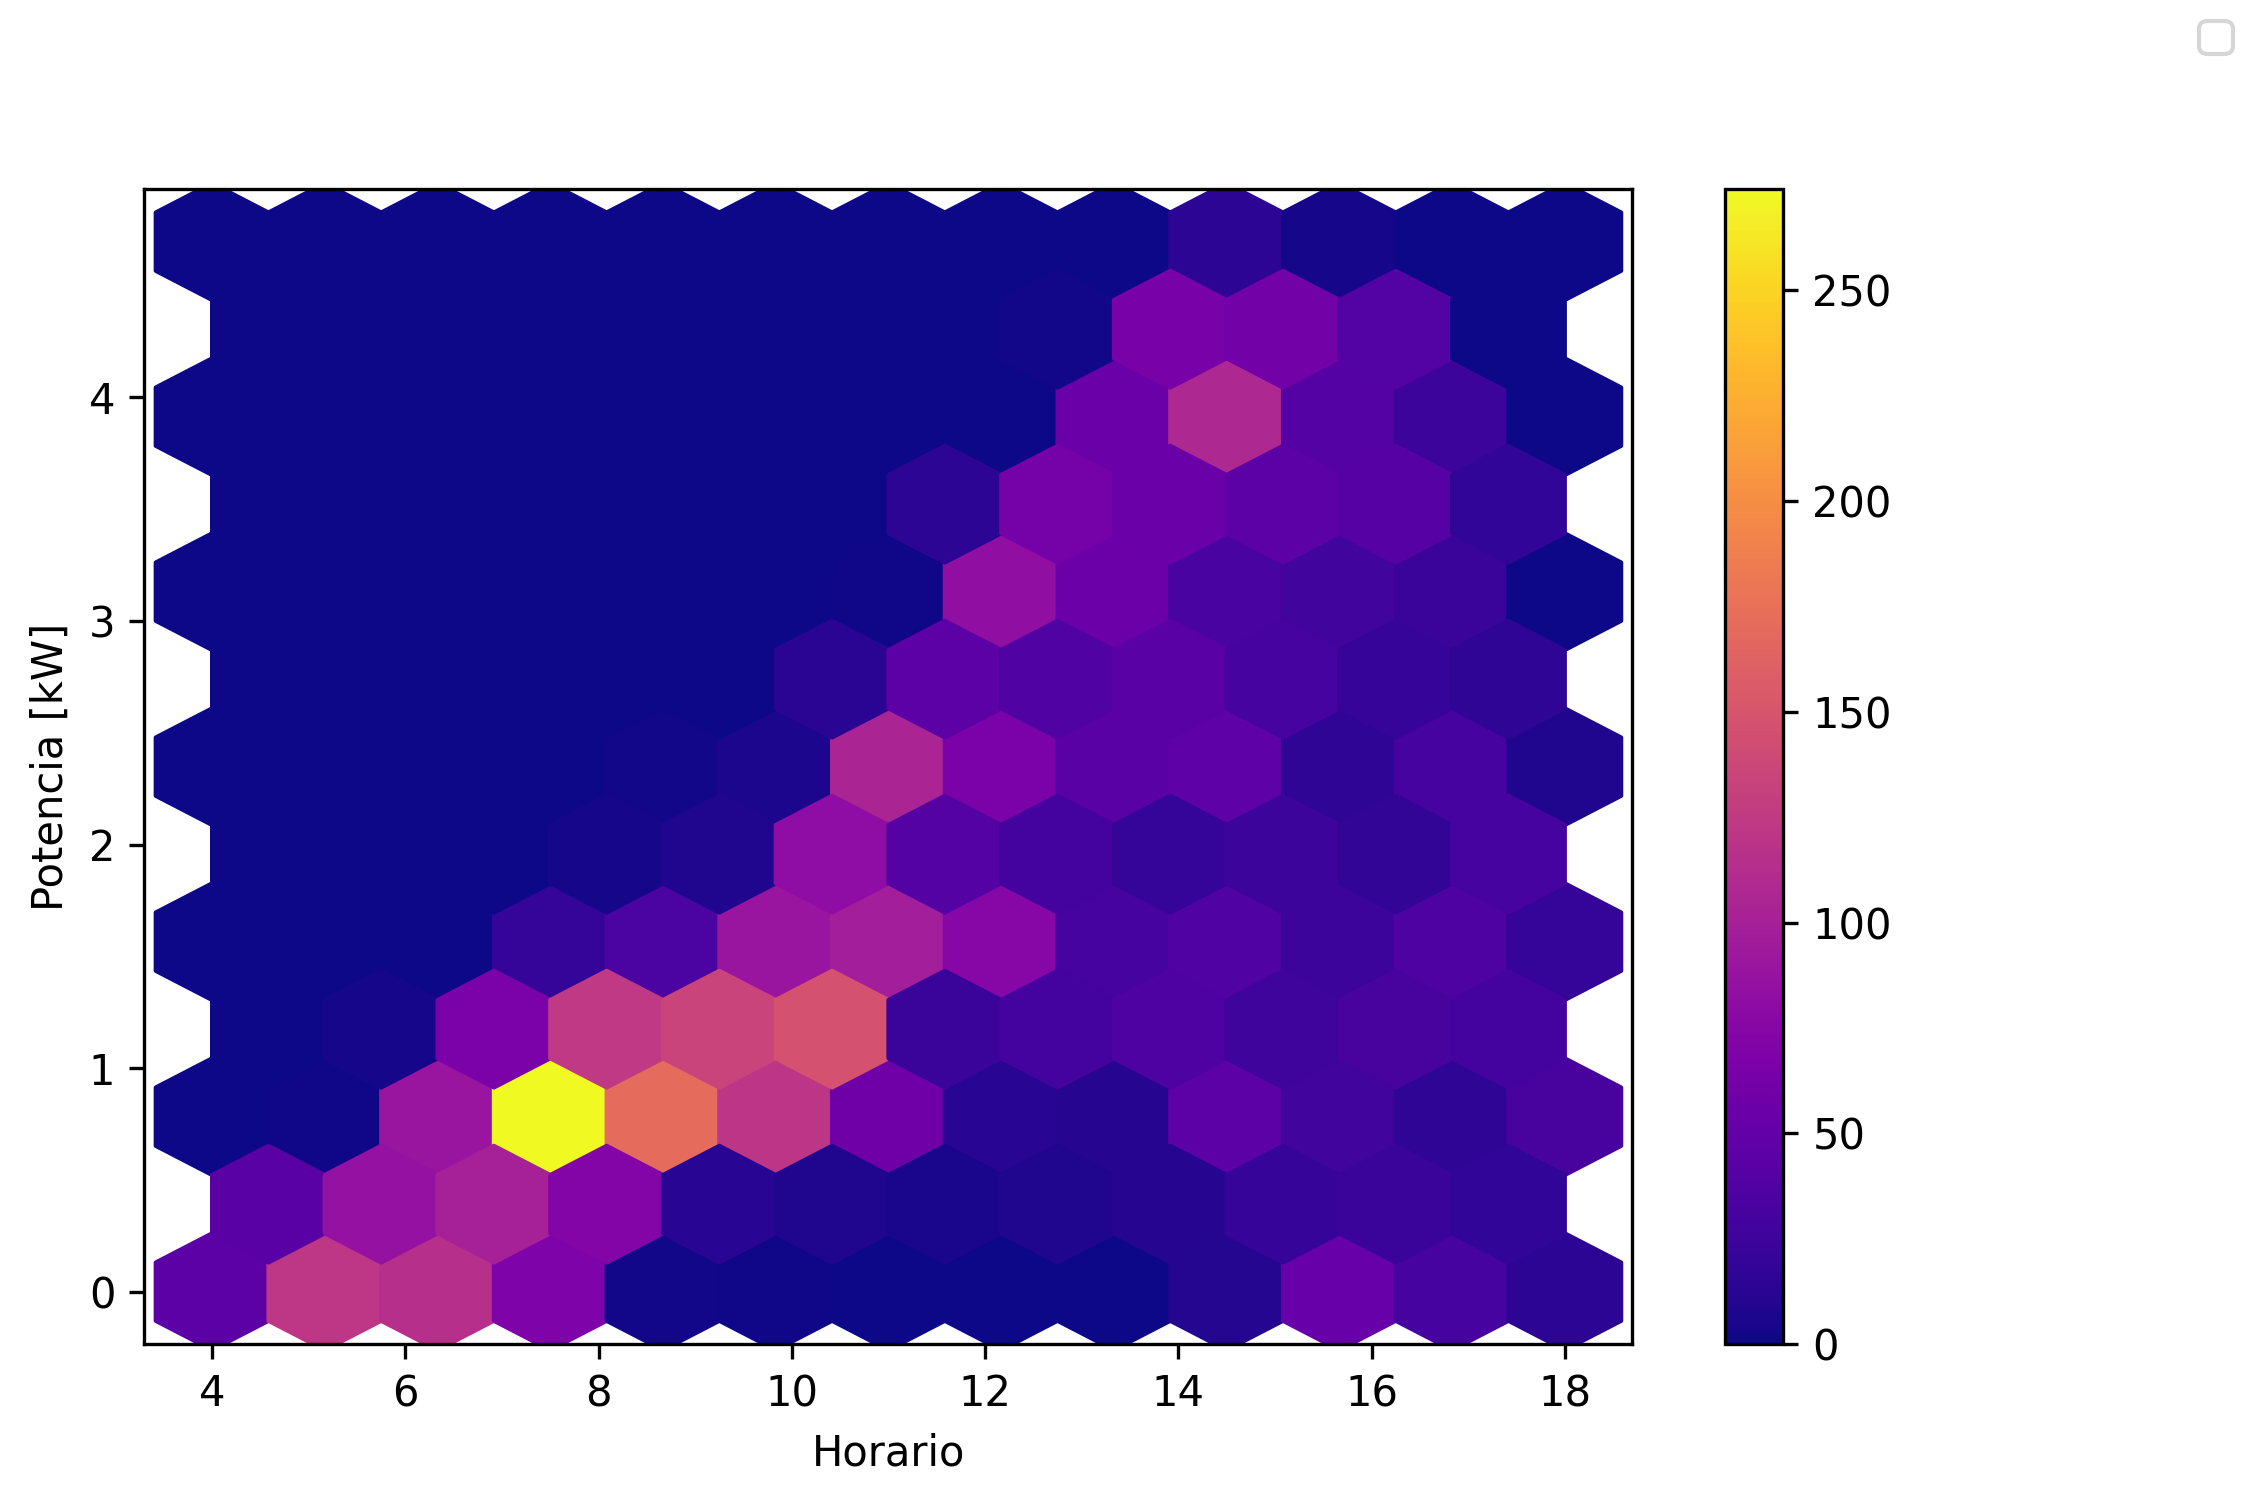

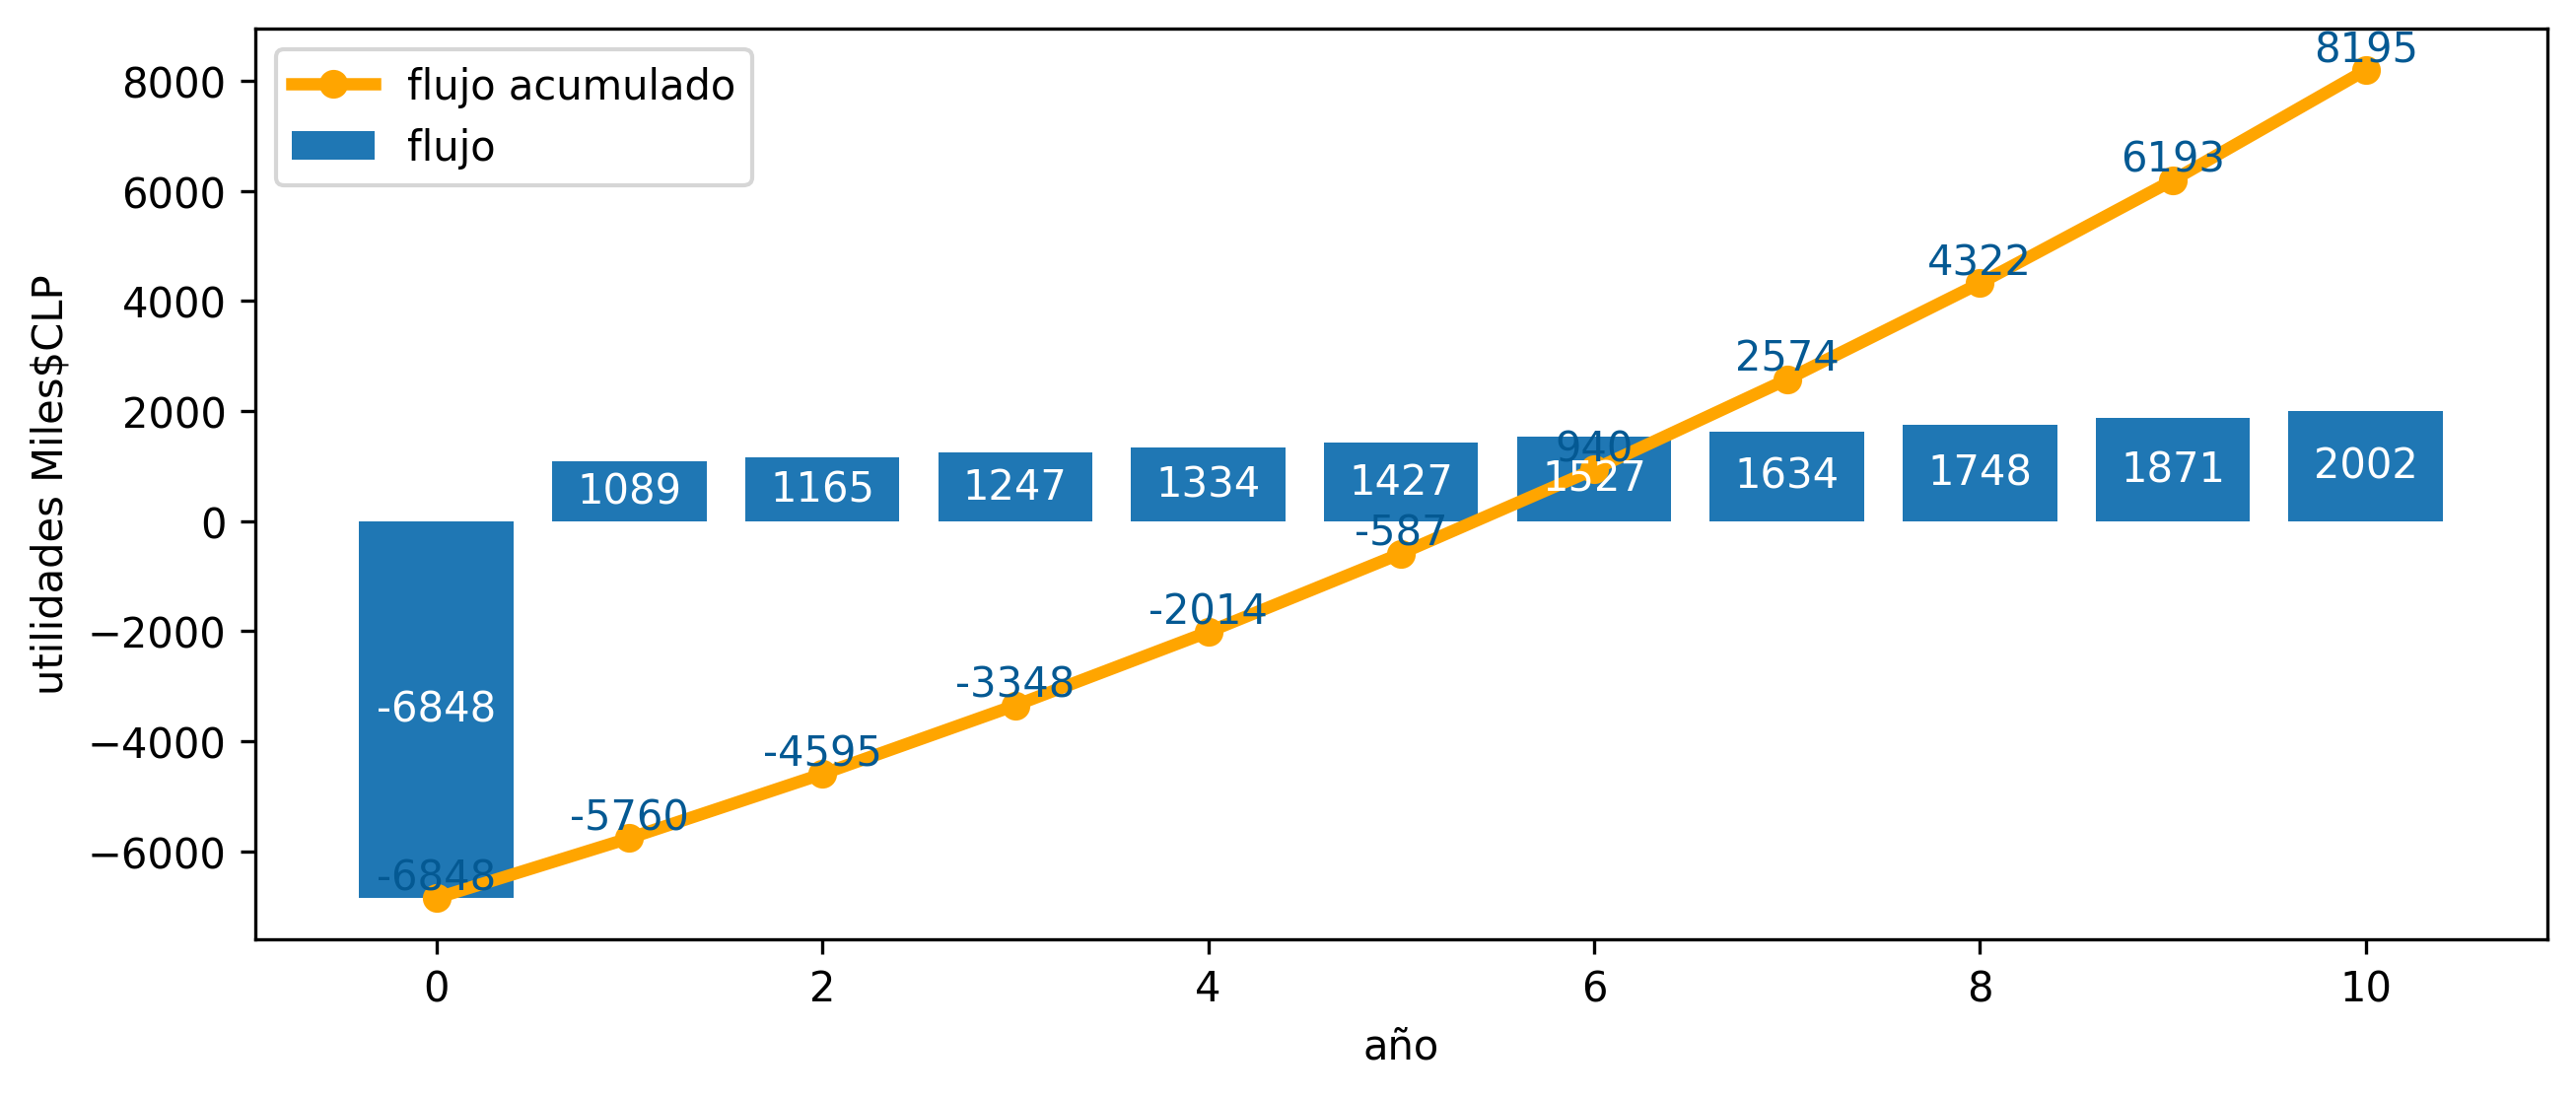

In [30]:
#dep
from models.plotter import plotter
plotter(project,PATH)

In [31]:
#set into doc
plot_list = [
    'plot_consumption_forecast',
    'plot_irradiance',
    'plot_temperature',
    'plot_components',
    'plot_components_irr',
    'plot_components_production',
    'plot_production_performance',
    'plot_performance_frequency',
    'plot_flux',
]

for plot in plot_list:
    memory_report.replace_pic(plot,PATH+f'{plot}.png')
    print('replaced plot:',plot)

replaced plot: plot_consumption_forecast
replaced plot: plot_irradiance
replaced plot: plot_temperature
replaced plot: plot_components
replaced plot: plot_components_irr
replaced plot: plot_components_production
replaced plot: plot_production_performance
replaced plot: plot_performance_frequency
replaced plot: plot_flux


1


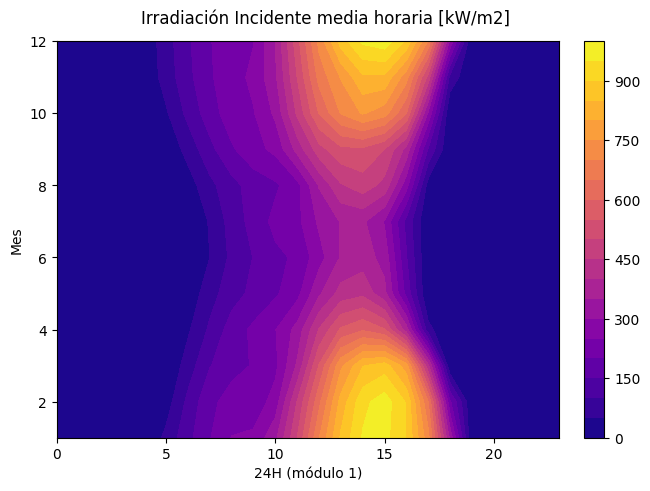

In [73]:
from matplotlib import pyplot as plt
import numpy as np
# cspell: disable
def plot_components_irr(project:Project,path:str):
    """plot each generation component irradiance on surface"""

    modules = project.production_array()
    n_modules = len(modules)
    print(len(modules))
    fig,axs = plt.subplots(n_modules,1,layout='constrained')
    fig.dpi = 100
    #fig.set_size_inches(9,7)

    for i,module in enumerate(modules):

        #pivot table
        pivot = module.fillna(0).pivot_table(index='month',columns='hour',values='IRR_incident')
        #meshgrid
        x,y = np.meshgrid(pivot.columns,pivot.index)
        z = pivot.values
        levels = np.linspace(0,1000,21)
        
        #plot fix por N size = 1 issue
        if n_modules == 1:
            axis = axs
        else:
            axis = axs[i]
        
        cs= axis.contourf(x,y,z,levels=levels,cmap='plasma')

        axis.set_xlabel(f'24H (módulo {1+i})')
        axis.set_ylabel('Mes')
        plt.colorbar(cs)

    fig.suptitle('Irradiación Incidente media horaria [kW/m2]')
        #plt.savefig(path+'plot_components_irr'+'.png',dpi=305)

plot_components_irr(project,PATH)

In [13]:
memory_report.save(PATH+f"reporte_memoria_calculo.docx")
bidding_report.save(PATH+f"reporte_pliegos_técnicos.docx")